In [5]:
import numpy as np
import scipy.io as sio
import scipy.linalg as la
import scipy
import scipy.integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
import os 


class planeSim(object):
    def __init__(self,Ni=[276,278],Namp=2e4):
        #load parameters
        prams=sio.loadmat('./prams.mat')
        Ac=prams['Ac']
        L=prams['L']
        Ec=prams['Ec']
        sig=prams['sig']
        ar=prams['ar'][0][0]
        ad=prams['ad'][0][0]
        memG=prams['memG'][0][0]
        memV=prams['memV'][0][0]
        gelec=prams['gelec'][0][0]
        gchem=prams['gchem'][0][0]
        beta=prams['beta'][0][0]
        tau=prams['tau'][0][0]
        
        Ac=Ac.T        
        
        # input vector I is defined here:
        N=279
        Iv=np.zeros((N,1))
        #give neurons indices in Ni an input amplitude of Namp
        if np.size(Namp)==1:
            if type(Namp)!=list:
                Namp=[Namp]
            Namp=Namp*len(Ni)
        for i,n in enumerate(Ni):
            Iv[n]=Namp[i]
        I=Iv
        self.I=I

        eqS=ar/(ar*sig+ad)*sig
        C=memG*np.eye(Ac.shape[0])+gelec*L+gchem*np.diag(np.squeeze(Ac.dot(eqS)))
        b=memG*memV+gchem*Ac.dot(eqS*Ec)+I
        self.C=C
        self.b=b
        eqV=la.lstsq(C,b)[0]
        xin=np.concatenate((eqV,eqS),0)
        self.xin=xin
        
        vmean=eqV+1/beta*np.log(1./sig-1)
        global pramlist
        #AcEc=Ac*(Ec.T)
        pramlist=[L,Ac,Ec,sig,ar,ad,memG,memV,gelec,gchem,beta,tau,vmean,N,I]
        
        fwd=sio.loadmat('./fwdMotion.mat')
        self.proj=fwd['projection']
    
    def runSim(self,tspan):
        rhs=lambda x,t: np.squeeze(goveq(x.reshape(-1,1)))
        x0=sio.loadmat('./CE100s.mat')
        x0=x0['x']
        x0=x0[np.random.randint(-122,0)]
        x=scipy.integrate.odeint(rhs,np.squeeze(x0),tspan,rtol=1e-9,atol=1e-9)
        V=self.proj.dot(x.T-self.xin);
        return V
 
def goveq(x):
    L,Ac,Ec,sig,ar,ad,memG,memV,gelec,gchem,beta,tau,vmean,N,I=pramlist
    v=x[:N]
    s=x[N:]
    dv=-1/tau*(memG*(v-memV)+gelec*(L.dot(v))+gchem*(v*(Ac.dot(s))-Ac.dot(s*Ec))-I)
    ds=1./(1.+np.exp(-beta*(v-vmean)))*ar*(1-s)-ad*s
    return np.concatenate((dv,ds),0)  


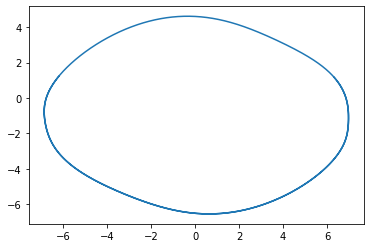

In [8]:
worm=planeSim()
T=2
h=1.0e-4
tspan=np.linspace(0,T,int(T/h+1))
V=worm.runSim(tspan)

plt.figure()
plt.plot(V[0],V[1])